# Machine Learning Pong

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [91]:
df = pd.read_csv('./data/game_log.csv')
df.head()

,ball_x,ball_y,ball_vx,ball_vy,paddle_y
0,770,300,-4,-4,277
1,766,296,-4,-4,277
2,762,292,-4,-4,277
3,758,288,-4,-4,277
4,754,284,-4,-4,277


In [92]:
df.shape

(18968, 5)

In [93]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ball_x,18968.0,396.492408,216.709626,22.0,210.0,398.0,586.0,770.0
ball_y,18968.0,299.050822,161.606442,20.0,160.0,296.0,440.0,580.0
ball_vx,18968.0,-0.043863,3.999865,-4.0,-4.0,-4.0,4.0,4.0
ball_vy,18968.0,0.005061,4.000102,-4.0,-4.0,4.0,4.0,4.0
paddle_y,18968.0,272.238138,84.313023,67.0,231.0,250.0,303.0,510.0


In [94]:
df.dropna(inplace=True)

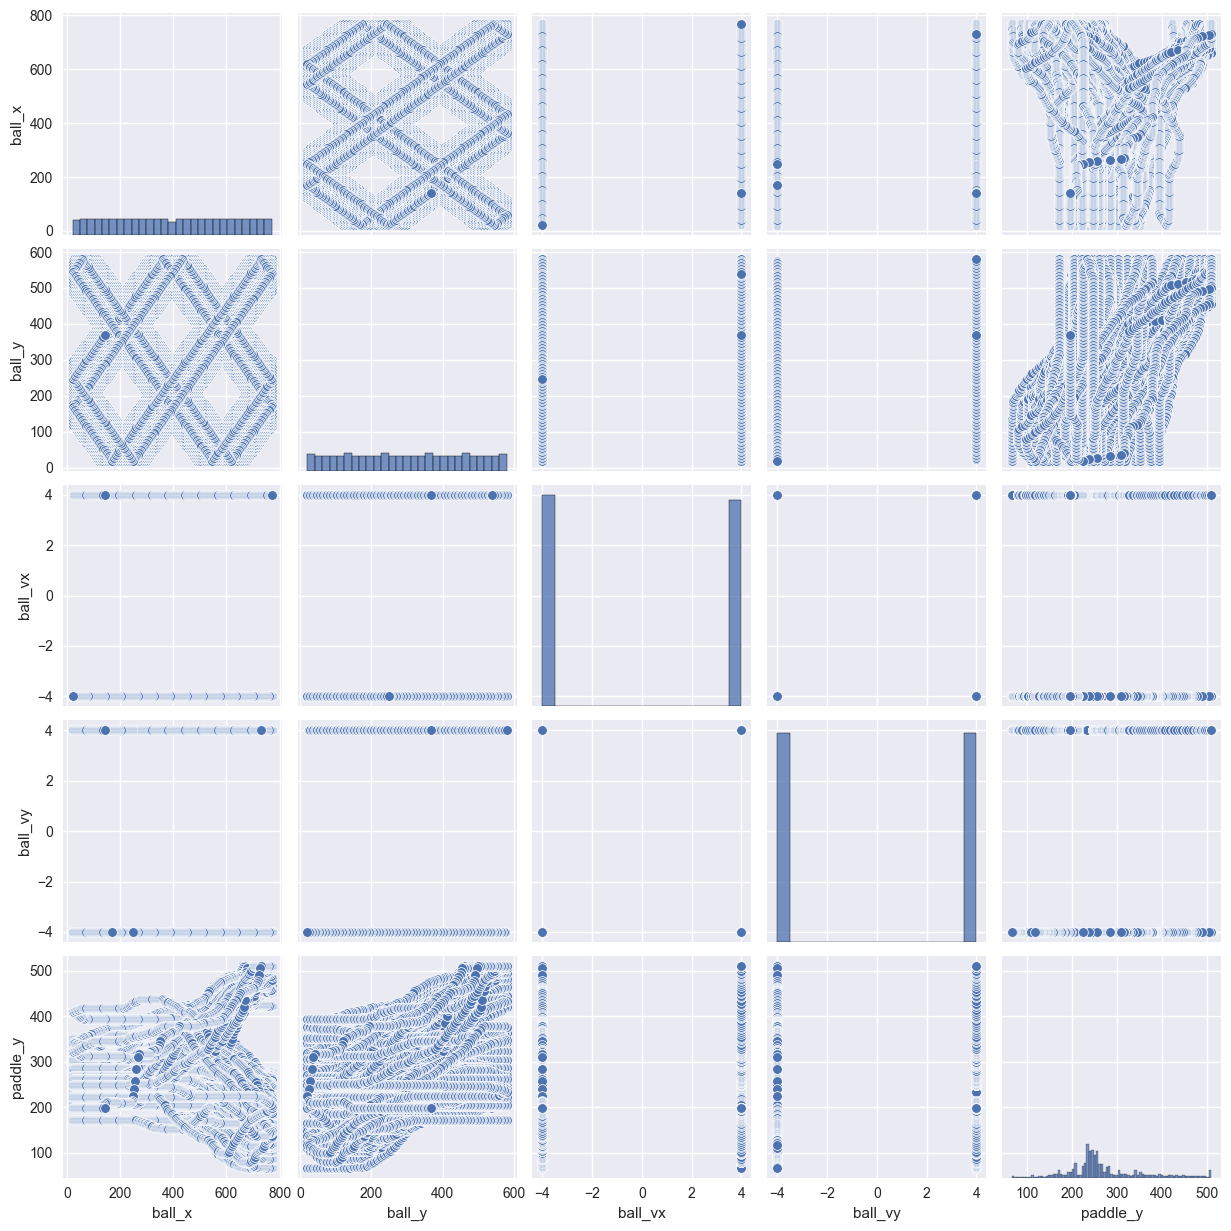

In [95]:
sns.pairplot(df)

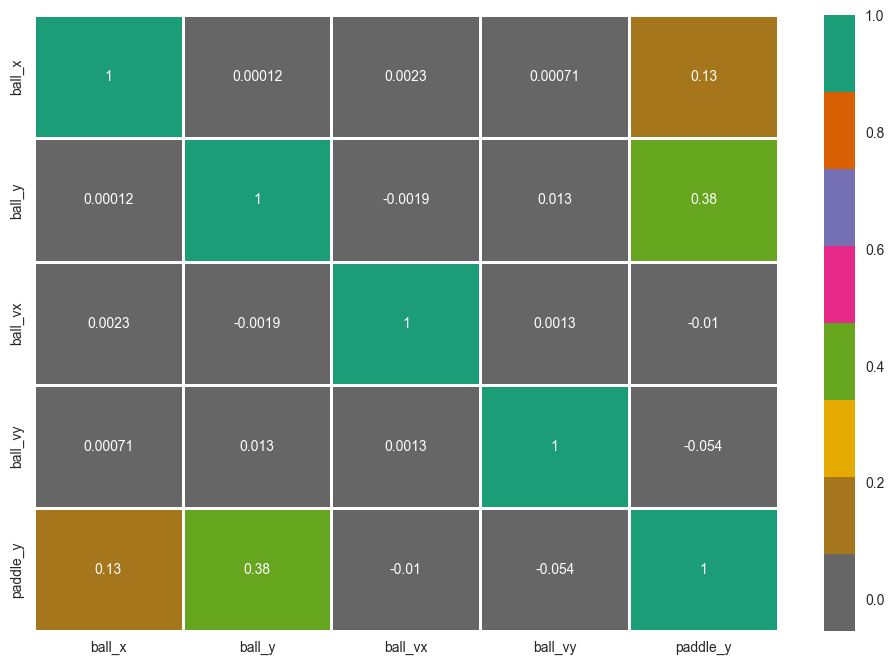

In [96]:
plt.figure(figsize=(12,8)) 
sns.heatmap(df.corr(), annot=True, cmap='Dark2_r', linewidths = 2)
plt.show()

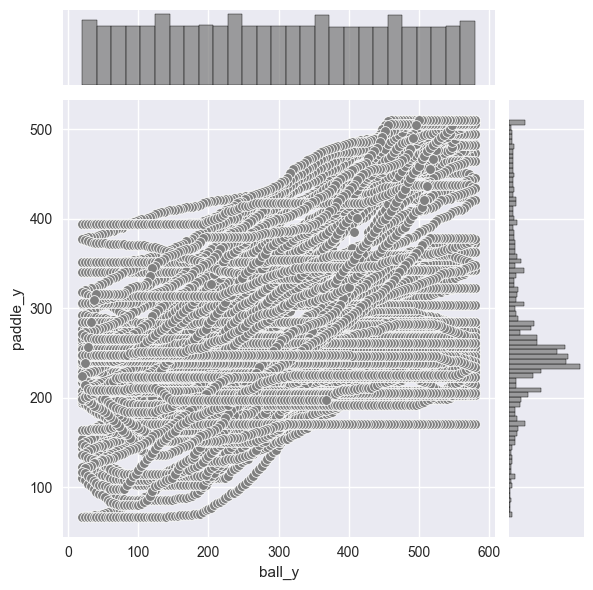

In [97]:
sns.jointplot(x='ball_y', y='paddle_y', data = df, color = 'gray')

In [98]:
def plot_random_scatter(dataframe, x_col, y_col, sample_size=180):
    sample_df = dataframe.sample(n=sample_size, random_state=42)
    plt.style.use('seaborn-v0_8')
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=sample_df, x=x_col, y=y_col, color='blue', edgecolor='w', s=60)
    plt.title('Scatter Plot of Random Sample')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.tight_layout()

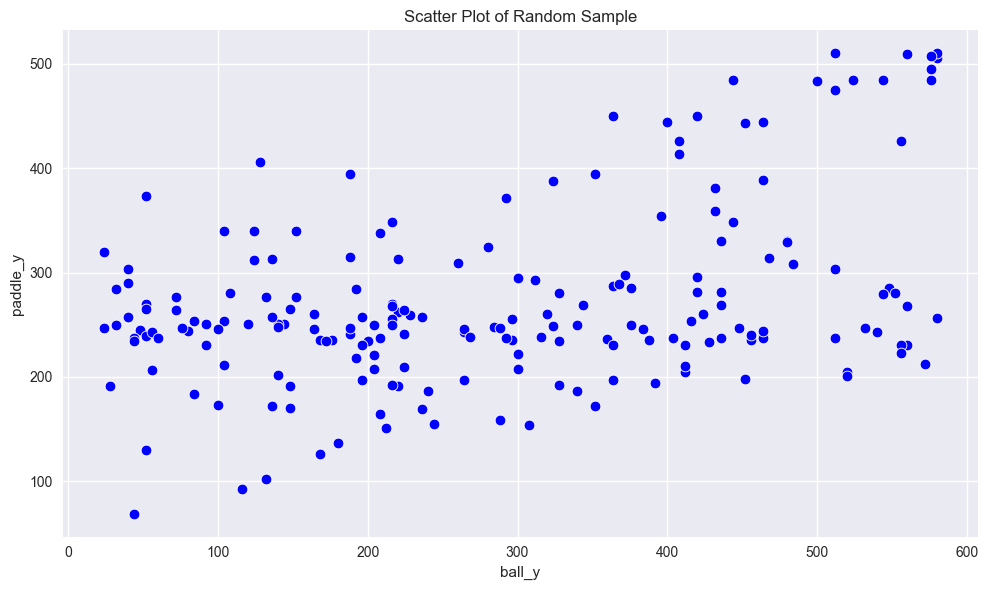

In [99]:
plot_random_scatter(df, 'ball_y', 'paddle_y', 200)

In [100]:
X = df[['ball_x', 'ball_y', 'ball_vx', 'ball_vy']].values  # Features
y = df['paddle_y']  # Target

In [101]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [102]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [103]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [131]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=12, include_bias=False)
X_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
lr_poly_model = LinearRegression()
lr_poly_model.fit(X_poly, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [104]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [116]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(hidden_layer_sizes=(128, 128), max_iter=10000, random_state=42)
mlp_model.fit(X_train, y_train)

,loss,'squared_error'
,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,10000
,shuffle,True


In [137]:
print(f"Number of inputs:  {mlp_model.n_features_in_}")
print(f"Number of outputs: {mlp_model.n_outputs_}")
print(f"Number of layers:  {mlp_model.n_layers_}")
print(f"Layer sizes: {[l.shape for l in mlp_model.coefs_]}")

Number of inputs:  4
Number of outputs: 1
Number of layers:  4
Layer sizes: [(4, 128), (128, 128), (128, 1)]


In [133]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate(model, test_set, name):
    y_pred = model.predict(test_set)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{name} - MSE: {mse:.2f}, R²: {r2:.2f}')

evaluate(lr_model, X_test, 'Linear Regression')
evaluate(lr_poly_model, X_test_poly, 'Polynomial Regression')
evaluate(rf_model, X_test, 'Random Forest')
evaluate(mlp_model, X_test, 'MLP Regressor')

Linear Regression - MSE: 5896.97, R²: 0.16
Polynomial Regression - MSE: 585.04, R²: 0.92
Random Forest - MSE: 602.60, R²: 0.91
MLP Regressor - MSE: 563.73, R²: 0.92


In [135]:
import joblib

def save_model(model):
    joblib.dump(mlp_model, './model/ml_model.pkl')
    joblib.dump(scaler, './model/scaler.pkl')

In [136]:
save_model(mlp_model)